In [5]:
from astropy.io import fits
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import redh3p as rhp
from PIL import Image

from lmfit import Model

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import os
import ipynbname
nb_path = str(ipynbname.path())
spec_dir = os.path.join(os.path.abspath(nb_path + '/../../../'), 'spec/')

fits_path_36 = spec_dir+'order36/new_frame/*.fits'
fits_path_35 = spec_dir+'order35/new_frame/*.fits'
fits_path_37 = spec_dir+'order37/new_frame/*.fits'
header_path = spec_dir+'jun02s*'

order36_data = rhp.read_file(path=fits_path_36)
order35_data = rhp.read_file(path=fits_path_35)
order37_data = rhp.read_file(path=fits_path_37)

int0 = 22
flat0 = 32
flat1 = 41
dark0 = 22
dark1 = 31

avg_flat_order36 = rhp.calc_avg(data=order36_data, start=flat0, stop=flat1, init=int0)
avg_dark_order36 = rhp.calc_avg(data=order36_data, start=dark0, stop=dark1, init=int0)

avg_flat_order35 = rhp.calc_avg(data=order35_data, start=flat0, stop=flat1, init=int0)
avg_dark_order35 = rhp.calc_avg(data=order35_data, start=dark0, stop=dark1, init=int0)

avg_flat_order37 = rhp.calc_avg(data=order37_data, start=flat0, stop=flat1, init=int0)
avg_dark_order37 = rhp.calc_avg(data=order37_data, start=dark0, stop=dark1, init=int0)

spec36_reducelist = []
spec35_reducelist = []
spec37_reducelist = []

sky_frame = [51,59,60,72,78,79,91,103]

for fn in range(51,59):
    if fn in sky_frame:
        continue
    else:
        skyframe36 = rhp.scale_sky_frame(data=order36_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        skyframe35 = rhp.scale_sky_frame(data=order35_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        skyframe37 = rhp.scale_sky_frame(data=order37_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        
        reduce_spec36 = (order36_data[fn-int0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        reduce_spec36[reduce_spec36<0] = 0
        
        reduce_spec35 = (order35_data[fn-int0] - skyframe35) / (avg_flat_order35 - avg_dark_order35)
        reduce_spec35[reduce_spec35<0] = 0
        reduce_spec35 = np.delete(reduce_spec35, np.s_[:8], 0)
        
        reduce_spec37 = (order37_data[fn-int0] - skyframe37) / (avg_flat_order37 - avg_dark_order37)
        reduce_spec37[reduce_spec37<0] = 0
        reduce_spec37 = np.vstack((reduce_spec37, np.zeros((7, 1024))))
    
        spec36_reducelist.append(reduce_spec36)
        spec35_reducelist.append(reduce_spec35)
        spec37_reducelist.append(reduce_spec37)
        
spec36_reduced = np.array(spec36_reducelist)
spec35_reduced = np.array(spec35_reducelist)
spec37_reduced = np.array(spec37_reducelist)

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange35 = fits.open(spec_dir + 'order35/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange37 = fits.open(spec_dir + 'order37/' + 'waverange.fits', ignore_missing_end=True)[0].data

R36 = 73194.84858495607
R35 = 73234.23454151815
R37 = 72736.04543958924
R = np.mean((R36,R35,R37))

modeA36 = order36_data[43-int0] + order36_data[46-int0] +\
        order36_data[47-int0] + order36_data[50-int0]
modeB36 = order36_data[44-int0] + order36_data[45-int0] +\
        order36_data[48-int0] + order36_data[49-int0]

modeA35 = order35_data[43-int0] + order35_data[46-int0] +\
        order35_data[47-int0] + order35_data[50-int0]
modeB35 = order35_data[44-int0] + order35_data[45-int0] +\
        order35_data[48-int0] + order35_data[49-int0]

modeA37 = order37_data[43-int0] + order37_data[46-int0] +\
        order37_data[47-int0] + order37_data[50-int0]
modeB37 = order37_data[44-int0] + order37_data[45-int0] +\
        order37_data[48-int0] + order37_data[49-int0]

exp_star = 20

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star

modeAB35 = ((modeA35 - modeB35)/4)/(avg_flat_order35 - avg_dark_order35)/exp_star
modeAB35 = np.delete(modeAB35, np.s_[:8], 0)

modeAB37 = ((modeA37 - modeB37)/4)/(avg_flat_order37 - avg_dark_order37)/exp_star
modeAB37 = np.vstack((modeAB37, np.zeros((7, 1024))))

flux36_model = Model(rhp.gaussian_fit)
flux35_model = Model(rhp.gaussian_fit)
flux37_model = Model(rhp.gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add('a0', value=0.005, min=0, max=0.01)
flux36_params.add('a1', value=71, min=68, max=74)
flux36_params.add('a2', value=2, min=0.5, max=5)
flux36_params.add('a3', value=0)
flux36_params.add('a4', value=0)
flux36_params.add('a5', value=0)

flux35_params = flux35_model.make_params()
flux35_params.add('a0', value=0.004, min=0, max=0.01)
flux35_params.add('a1', value=73, min=70, max=76)
flux35_params.add('a2', value=2, min=0.5, max=5)
flux35_params.add('a3', value=0)
flux35_params.add('a4', value=0)
flux35_params.add('a5', value=0)

flux37_params = flux37_model.make_params()
flux37_params.add('a0', value=0.004, min=0, max=0.01)
flux37_params.add('a1', value=71, min=68, max=74)
flux37_params.add('a2', value=2, min=0.5, max=5)
flux37_params.add('a3', value=0)
flux37_params.add('a4', value=0)
flux37_params.add('a5', value=0)

lower = 0
upper = 1024

spat_axis = np.linspace(0,263,264)

star36_a0 = np.zeros(np.size(modeAB36,1))
star36_a2 = np.zeros(np.size(modeAB36,1))

star35_a0 = np.zeros(np.size(modeAB35,1))
star35_a2 = np.zeros(np.size(modeAB35,1))

star37_a0 = np.zeros(np.size(modeAB37,1))
star37_a2 = np.zeros(np.size(modeAB37,1))

for i in range(lower, upper):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_axis)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order36')
        
    try:
        flux35_fit_result = flux35_model.fit(modeAB35.T[i], flux35_params, x=spat_axis)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order35')
        
    try:
        flux37_fit_result = flux37_model.fit(modeAB37.T[i], flux37_params, x=spat_axis)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order37')
        
    star36_a0[i] = flux36_fit_result.params['a0'].value
    star36_a2[i] = flux36_fit_result.params['a2'].value
    
    star35_a0[i] = flux35_fit_result.params['a0'].value
    star35_a2[i] = flux35_fit_result.params['a2'].value
    
    star37_a0[i] = flux37_fit_result.params['a0'].value
    star37_a2[i] = flux37_fit_result.params['a2'].value
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10
m_lambda = 6.787 # Kmag HD 109840
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb36 = F_a0 * ((lambda_aw/waverange36)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange36*T)) - 1))

Fbb35 = F_a0 * ((lambda_aw/waverange35)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange35*T)) - 1))

Fbb37 = F_a0 * ((lambda_aw/waverange37)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange37*T)) - 1))


star36_fwhm = star36_a2*(np.sqrt(2*np.log(2))*2)
Fobs36 = star36_a0 * star36_fwhm

star35_fwhm = star35_a2*(np.sqrt(2*np.log(2))*2)
Fobs35 = star35_a0 * star35_fwhm

star37_fwhm = star37_a2*(np.sqrt(2*np.log(2))*2)
Fobs37 = star37_a0 * star37_fwhm

Fc36 = Fbb36/Fobs36

Fc35 = Fbb35/Fobs35

Fc37 = Fbb37/Fobs37

width = np.size(spec36_reduced, axis=1)
length = np.size(spec36_reduced, axis=2)

slit_area36 = 0.1*width*2.908e-5*length

slit_area35 = 0.1*width*2.999e-5*length

slit_area37 = 0.1*width*2.859e-5*length

exp_spec = 60

fjc36_list = []
fjc35_list = []
fjc37_list = []

for i in range(np.size(spec36_reduced, axis=0)):
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    fjc35_list.append(spec35_reduced[i] / exp_spec * Fc35 * 4.2535e10 / slit_area35)
    fjc37_list.append(spec37_reduced[i] / exp_spec * Fc37 * 4.2535e10 / slit_area37)
    
fjc36 = np.array(fjc36_list)
fjc35 = np.array(fjc35_list)
fjc37 = np.array(fjc37_list)

st_list = []

for i in range(np.size(fjc36, axis=0)):
    s1a = np.delete(fjc36[i], np.s_[439:], 1)
    s1b = np.delete(s1a, np.s_[:399], 1)
    s1b = scipy.ndimage.shift(s1b, -0.454378, order=3, mode='nearest')
    # y:1:n:0

    s3a = np.delete(fjc36[i], np.s_[539:], 1)
    s3b = np.delete(s3a, np.s_[:499], 1)
    s3b = scipy.ndimage.shift(s3b, -0.076430, order=3, mode='nearest')
    # y:2:n:1

    s6a = np.delete(fjc36[i], np.s_[140:], 1)
    s6b = np.delete(s6a, np.s_[:100], 1)
    s6b = scipy.ndimage.shift(s6b, 15.041735, order=3, mode='nearest')
    # y:3:n:3

    s7a = np.delete(fjc37[i], np.s_[443:], 1)
    s7b = np.delete(s7a, np.s_[:403], 1)
    s7b = scipy.ndimage.shift(s7b, -3.293717, order=3, mode='nearest')
    # y:4:n:3

    s8a = np.delete(fjc35[i], np.s_[532:], 1)
    s8b = np.delete(s8a, np.s_[:492], 1)
    s8b = scipy.ndimage.shift(s8b, 0.235798, order=3, mode='nearest')
    # y:5:n:3

    s9a = np.delete(fjc36[i], np.s_[86:], 1)
    s9b = np.delete(s9a, np.s_[:46], 1)
    s9b = scipy.ndimage.shift(s9b, 0.155569, order=3, mode='nearest')
    # y:6:n:3

    s10a = np.delete(fjc36[i], np.s_[323:], 1)
    s10b = np.delete(s10a, np.s_[:283], 1)
    s10b = scipy.ndimage.shift(s10b, 10.464537, order=3, mode='nearest')
    # y:7:n:3

    s11a = np.delete(fjc35[i], np.s_[185:], 1)
    s11b = np.delete(s11a, np.s_[:145], 1)
    s11b = scipy.ndimage.shift(s11b, -0.288932, order=3, mode='nearest')
    # y:8:n:3

    s12a = np.delete(fjc35[i], np.s_[811:], 1)
    s12b = np.delete(s12a, np.s_[:771], 1)
    s12b = scipy.ndimage.shift(s12b, -0.489157, order=3, mode='nearest')
    # y:9:n:3

    s14a = np.delete(fjc35[i], np.s_[727:], 1)
    s14b = np.delete(s14a, np.s_[:687], 1)
    s14b = scipy.ndimage.shift(s14b, -6.983206, order=3, mode='nearest')
    # y:10:n:4

    s15a = np.delete(fjc37[i], np.s_[510:], 1)
    s15b = np.delete(s15a, np.s_[:470], 1)
    s15b = scipy.ndimage.shift(s15b, -0.570506, order=3, mode='nearest')
    # y:11:n:4

    stt = s1b+s3b+s6b+s7b+s8b+s9b+s10b+s11b+s12b+s14b+s15b
    
    st_list.append(stt)

st = np.array(st_list)

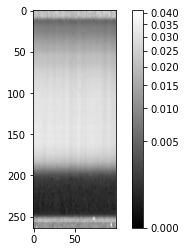

In [2]:
st_list = []
# smooth = []
for i in range(np.size(fjc36, axis=0)):
    rs1a = np.delete(fjc36[i], np.s_[800:], 1)
    rs1b = np.delete(rs1a, np.s_[:700], 1)

    rs3a = np.delete(fjc37[i], np.s_[800:], 1)
    rs3b = np.delete(rs3a, np.s_[:700], 1)

    rs4a = np.delete(fjc35[i], np.s_[500:], 1)
    rs4b = np.delete(rs4a, np.s_[:400], 1)
    
    stt = rs1b+rs3b+rs4b
        
    st_list.append(stt)
    
st = np.array(st_list)

# rs1a = np.delete(spec36_stacked, np.s_[800:], 1)
# rs1b = np.delete(rs1a, np.s_[:700], 1)

# rs3a = np.delete(spec37_stacked, np.s_[800:], 1)
# rs3b = np.delete(rs3a, np.s_[:700], 1)

# rs4a = np.delete(spec35_stacked, np.s_[500:], 1)
# rs4b = np.delete(rs4a, np.s_[:400], 1)

plt.figure()
plt.imshow(np.sum(st, axis=0), cmap='gist_gray', norm=colors.PowerNorm(gamma=0.4))
plt.colorbar()

In [3]:
# create empty list to collect result
background_scan = []

fn0 = 0
fn1 = np.size(st,0)

upper = 245
lower = 10

print('BLANK LOOP START')
for fn in range(fn0, fn1):
    blank = np.zeros(301)
    
    stack = st[fn]
    
    blank = np.zeros(301)      
            
    # fit gaussian to selected range of spatial axis of a frame
    for i in range(lower, upper):               
            blank[i] = np.median(stack[i])
    
    # Collect fitting parameters of each frame number   
    background_scan.append(blank)
    
print('DONE')

BLANK LOOP START
DONE


Text(0, 0.5, 'Frame Number')

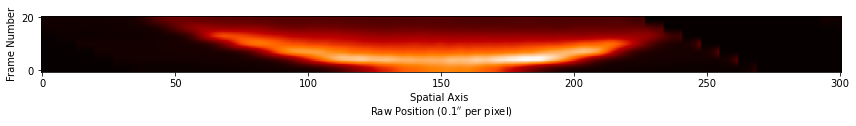

In [33]:
backgr_raw = np.vstack(background_scan)

for i in range(len(backgr_raw)):
    backgr_raw[i,:] = scipy.ndimage.shift(backgr_raw[i,:], i*7, order=5)
    
backgr_sh = np.roll(backgr_raw, 22, axis=1)
backgr_sh = np.flip(backgr_sh, 1)

reback = np.array(Image.fromarray(backgr_sh).resize(size=(301, 21)))

fig = plt.figure(figsize=(12,9), tight_layout=True)

fig.add_subplot(311)
plt.imshow(reback, cmap='gist_heat', norm=colors.PowerNorm(gamma=1), origin='lower')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')

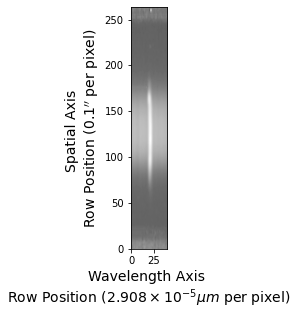

In [25]:
spt = np.delete(st[0], np.s_[1000:], axis=1)
x = waverange36[0:1000]

fig = plt.figure(figsize=(20,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(spt, aspect='equal', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.3))
plt.xlabel('Wavelength Axis \nRow Position '+r'($2.908 \times 10^{-5} \mu m$ per pixel)', fontsize=14)
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
plt.ticklabel_format(useOffset=False)
# plt.title('a) Order 35 H$_2$ and H$_3^{+}$ emission lines', fontsize=16)
plt.gca().invert_yaxis()

# fig.add_subplot(212)
# plt.plot(x[:], spt[120][:], 'k')
# plt.xlim(x[0], x[-1])

In [26]:
# extract H3+ properties by fitting gaussian curve to the emission lines
h3p_a0_map = []
h3p_a1_map = []
h3p_fwhm_map = []
h3p_a0_map_error = []
h3p_a1_map_error = []
h3p_fwhm_map_error = []


fn0 = 0
fn1 = np.size(st,0)

upper_h3p = 245
lower_h3p = 10

print('H3p LOOP START')
for fn in range(fn0, fn1):
    print('Frame Number = ' + str(fn))

    h3p_a0 = np.zeros(301)
    h3p_a1 = np.zeros(301)
    h3p_a2 = np.zeros(301)
    h3p_a0_error = np.zeros(301)
    h3p_a1_error = np.zeros(301)
    h3p_a2_error = np.zeros(301)
    
    stack = st[fn]
    
    pixel = np.linspace(0, np.size(stack,1)-1, np.size(stack,1))
    
    for i in range(lower_h3p, upper_h3p):
        # create lmfit model with defined gaussian
        h3p_model = Model(rhp.gaussian_fit)

        # create parameters and add initial guess
        h3p_params = h3p_model.make_params()
        h3p_params.add('a0', value=0.03, min=0, max=0.5)
        h3p_params.add('a1', value=20, min=17, max=23)
        h3p_params.add('a2', value=2, min=0, max=6)
        h3p_params.add('a3', value=0)
        h3p_params.add('a4', value=0)
        h3p_params.add('a5', value=0)
        
        # perform gaussian fit and test errors
        try:
            h3p_fit_result = h3p_model.fit(stack[i], h3p_params, x=pixel)
        except ValueError:
            print('ValueError occured at i=' + str(i))
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(pixel, stack[i])
            plt.plot(pixel, h3p_fit_result.best_fit, 'r-', label='best fit')
        
        # collect fitting parameters
        h3p_a0[i] = h3p_fit_result.params['a0'].value
        h3p_a1[i] = h3p_fit_result.params['a1'].value
        h3p_a2[i] = h3p_fit_result.params['a2'].value
        h3p_a0_error[i] = h3p_fit_result.params['a0'].stderr
        h3p_a1_error[i] = h3p_fit_result.params['a1'].stderr
        h3p_a2_error[i] = h3p_fit_result.params['a2'].stderr
        
    # collect fitting parameters of each frame number and calibrate errors
    h3p_a0_map.append(h3p_a0)
    h3p_a1_map.append(h3p_a1)
    h3p_fwhm_map.append(h3p_a2 * (np.sqrt(2*np.log(2))*2))
    
    h3p_a0_error[h3p_a0_error > 10] = 1e10
    h3p_a0_error[np.isnan(h3p_a0_error)] = 1e10
    h3p_a0_map_error.append(h3p_a0_error)
    
    
    h3p_a1_error[h3p_a1_error > 10] = 1e10
    h3p_a1_error[np.isnan(h3p_a1_error)] = 1e10
    h3p_a1_map_error.append(h3p_a1_error)
    
    h3p_a2_error[h3p_a2_error > 10] = 1e10
    h3p_a2_error[np.isnan(h3p_a2_error)] = 1e10  
    h3p_fwhm_map_error.append(h3p_a2_error * (np.sqrt(2*np.log(2))*2))
    
print('DONE')

H3p LOOP START
Frame Number = 0
Frame Number = 1
Frame Number = 2
Frame Number = 3
Frame Number = 4
Frame Number = 5
Frame Number = 6
DONE


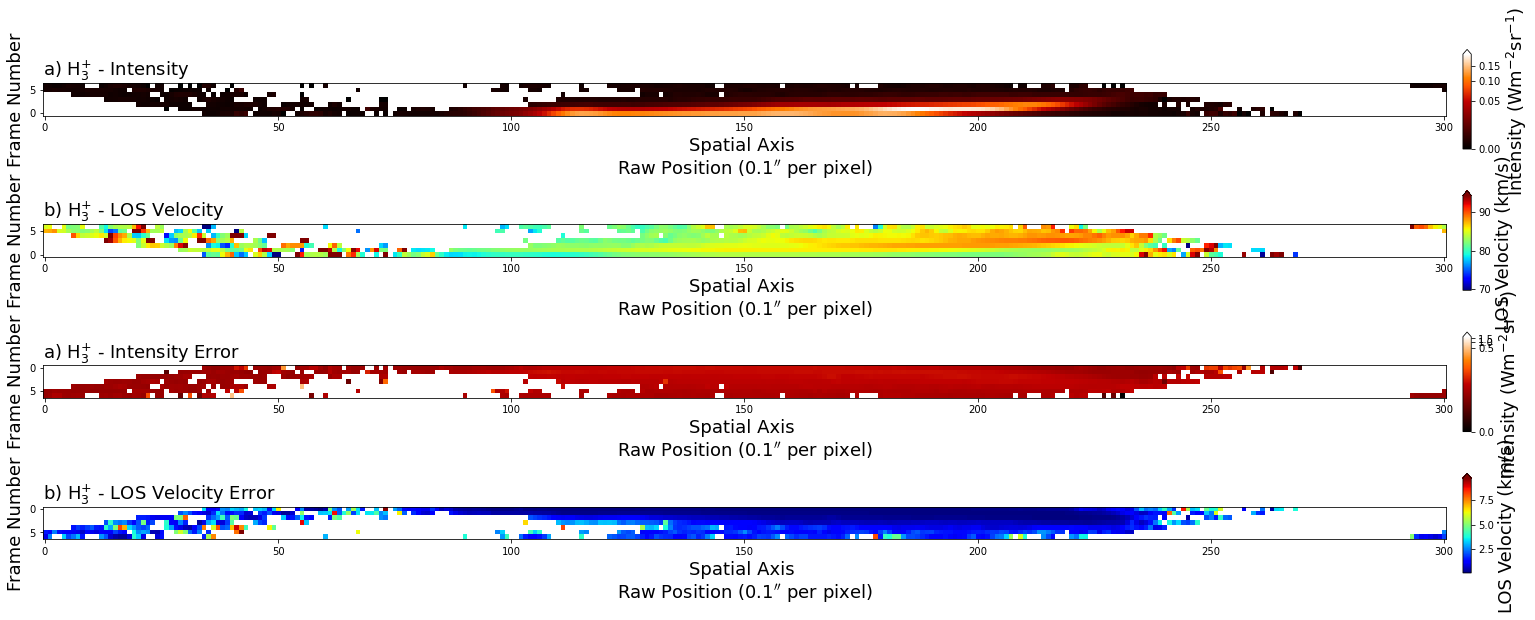

In [43]:
# data
h3p_a0 = np.vstack((h3p_a0_map))
h3p_a1 = np.vstack((h3p_a1_map))
h3p_fwhm = np.vstack((h3p_fwhm_map))

h3p_int = h3p_a0*h3p_fwhm

h3p_int_shifted = h3p_int*1.

for i in range(len(h3p_int)):
    h3p_int_shifted[i,:] = scipy.ndimage.shift(h3p_int[i,:], i*7, order=5)
    
h3p_int_shifted = np.roll(h3p_int_shifted, 22, axis=1)
h3p_int_shifted = np.flip(h3p_int_shifted, 1)

h3p_los = h3p_a1/R*3e5*np.cos(3.098*np.pi/180)

h3p_los_shifted = h3p_los*1.

for i in range(len(h3p_los)):
    h3p_los_shifted[i,:] = scipy.ndimage.shift(h3p_los[i,:], i*7, order=5)
    
h3p_los_shifted = np.roll(h3p_los_shifted, 22, axis=1)
h3p_los_shifted = np.flip(h3p_los_shifted, 1)


# error
h3p_a0_error = np.vstack((h3p_a0_map_error))
h3p_a1_error = np.vstack((h3p_a1_map_error))
h3p_fwhm_error = np.vstack((h3p_fwhm_map_error))

h3p_a0_error[h3p_a0_error==0]=1e10
h3p_a1_error[h3p_a1_error==0]=1e10
h3p_fwhm_error[h3p_fwhm_error==0]=1e10

h3p_a0[h3p_a0==0]=1e10
h3p_a1[h3p_a1==0]=1e10
h3p_fwhm[h3p_fwhm==0]=1e10

h3p_int_error = h3p_int*np.sqrt((h3p_a0_error/h3p_a0)**2+(h3p_fwhm_error/h3p_fwhm)**2)
h3p_los_error = h3p_a1_error/R*3e5*np.cos(3.098*np.pi/180)

h3p_int_shifted_error = h3p_int_error*1.
h3p_los_shifted_error = h3p_los_error*1.

for i in range(len(h3p_int_error)):
    h3p_int_shifted_error[i,:] = scipy.ndimage.shift(h3p_int_error[i,:], i*7, order=5)
    
for i in range(len(h3p_los_error)):
    h3p_los_shifted_error[i,:] = scipy.ndimage.shift(h3p_los_error[i,:], i*7, order=5)

h3p_int_shifted_error = np.roll(h3p_int_shifted_error, 22, axis=1)
h3p_int_shifted_error = np.flip(h3p_int_shifted_error, 1)
    
h3p_los_shifted_error = np.roll(h3p_los_shifted_error, 22, axis=1)
h3p_los_shifted_error = np.flip(h3p_los_shifted_error, 1)


h3p_int_shifted_error[h3p_int_shifted_error>=10] = np.nan
h3p_int_shifted_error[h3p_int_shifted_error<=1e-6] = np.nan
h3p_los_shifted_error[h3p_los_shifted_error>=10] = np.nan
h3p_los_shifted_error[h3p_los_shifted_error<=1e-6] = np.nan

h3p_int_shifted[np.isnan(h3p_int_shifted_error)] = np.nan
h3p_los_shifted[np.isnan(h3p_los_shifted_error)] = np.nan

# plots
h3p_int_re = np.array(Image.fromarray(h3p_int_shifted).resize(size=(301, 14)))
h3p_los_re = np.array(Image.fromarray(h3p_los_shifted).resize(size=(301, 14)))

fig = plt.figure(figsize=(24,8), tight_layout=True)

fig.add_subplot(411)
plt.imshow(h3p_int_shifted, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.5), origin='lower')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(412)
plt.imshow(h3p_los_shifted, cmap='jet', origin='lower')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

fig.add_subplot(413)
# colMap = cm.gist_heat
# colMap.set_bad(color='white')
plt.imshow(h3p_int_shifted_error, cmap='gist_heat', norm=colors.PowerNorm(gamma=0.1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('a) H$_3^{+}$ - Intensity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Intensity (Wm$^{-2}$sr$^{-1}$)',size=18)

fig.add_subplot(414)
plt.imshow(h3p_los_shifted_error, cmap='jet')
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.title('b) H$_3^{+}$ - LOS Velocity Error', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='LOS Velocity (km/s)',size=18)

In [44]:
hdu1 = fits.PrimaryHDU(h3p_int_shifted)
hdu1.writeto('sh3p_int_shifted.fits', overwrite=True)

hdu2 = fits.PrimaryHDU(h3p_los_shifted)
hdu2.writeto('sh3p_los_shifted.fits', overwrite=True)

hdu3 = fits.PrimaryHDU(h3p_int_shifted_error)
hdu3.writeto('sh3p_int_shifted_error.fits', overwrite=True)

hdu4 = fits.PrimaryHDU(h3p_los_shifted_error)
hdu4.writeto('sh3p_los_shifted_error.fits', overwrite=True)